In [3]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('/cellar/users/snwright/Git/Network_Evaluation_Tools/neteval/')

In [4]:
datadir='/cellar/users/snwright/Data/RareCommon'
refdir='/cellar/users/snwright/Data/RareCommon/Reference/'
outdir='/cellar/users/snwright/Data/RareCommon/Annotations'

# Dev Annotation Test


There are numerous ways to think about this. 

1. Test the set of rare genes and common genes against the background distribution - is it a random or skewed sample
2. Test the RO vs CO against each other, irrespective of the background (though can I use this background info - probably)
3. Test the shared vs all not shared
4. Do a multiple comparison between RO, CO and shared. 

In [5]:
files = {
    'Cite':'Gene_Citation_Dec23.txt', 'MisSyn': 'Gene_MisSyn.txt', 
    'Disgen':'Gene_disgen.txt', 'pli': 'Gene_pLI.txt',
    'dgi': 'Gene_DGI_scores.txt', 'omim': 'Gene_OMIM.txt', 
    'Length': 'Gene_length.txt', 'Prot': 'Gene_prot.txt',
    'GO': 'Gene_GO.txt' , 'phylop': 'Gene_PhyloP.txt',
    'mrna':'Gene_mRNA.txt'
}
annot_dir = '/cellar/users/snwright/Data/RareCommon/Annotations'

In [441]:
transform = {'Cite': np.log10,
 'MisSyn': None,
 'Disgen': np.log10,
 'pli': None,
 'dgi': np.log10,
 'omim': np.log10,
 'Length': np.log10,
 'Prot': None,
 'GO': np.log10,
 'phylop': None,
 'mrna': np.log10}

metric = {'Cite': np.median,
 'MisSyn': np.mean,
 'Disgen': np.median,
 'pli': np.median,
 'dgi': np.mean,
 'omim': np.mean,
 'Length': np.median,
 'Prot': np.median,
 'GO': np.median,
 'phylop': np.median,
 'mrna': np.median}

missing_val = {'Cite':0,
 'MisSyn': None,
 'Disgen': 0,
 'pli': None,
 'dgi': None,
 'omim': 0,
 'Length': None,
 'Prot': None,
 'GO': 0,
 'phylop': None,
 'mrna': None}

usecols = {'Cite': 'CitationCount',
 'MisSyn': 'mis.z_score',
 'Disgen': 'n_DISGENET',
 'pli': 'LOEUF',
 'dgi': 'mean_score',
 'omim': 'OMIM_count',
 'Length': 'GeneSize',
 'Prot': 'Mean_prot',
 'GO': 'n_GO',
 'phylop': 'PhyloP_mean',
 'mrna': 'Mean_mRNA'}

labels = {'Cite': 'Citation Count',
 'MisSyn': 'Missense intolerance',
 'Disgen': 'Disease Assoc.',
 'pli': 'LOEUF',
 'dgi': 'Drug Interactions',
 'omim': 'Mendelian Assoc',
 'Length': 'Gene Size',
 'Prot': 'Protein Abun.',
 'GO': 'GO Terms',
 'phylop': 'Gene Conservation',
 'mrna': 'mRNA Exp.'}

In [85]:
annot_dfs = {}
for met, file in files.items():
    annot_dfs[met] = pd.read_csv(os.path.join(annot_dir, file), sep='\t', index_col=0)

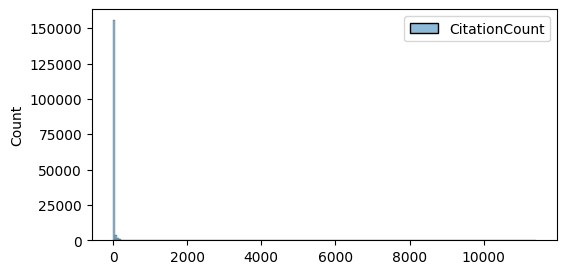

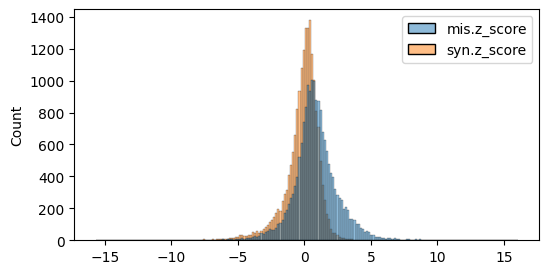

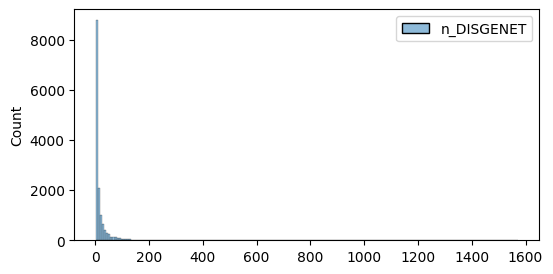

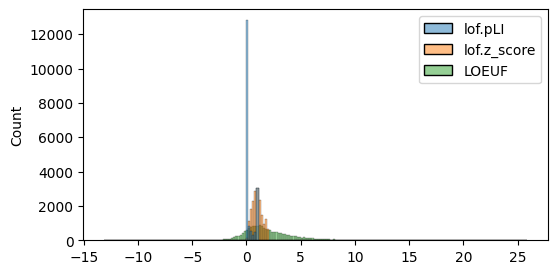

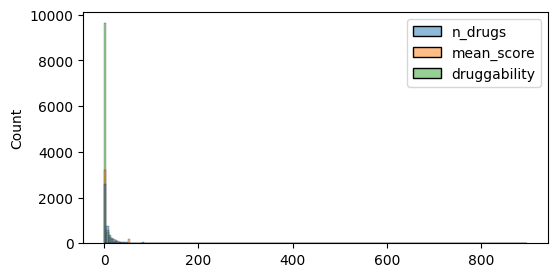

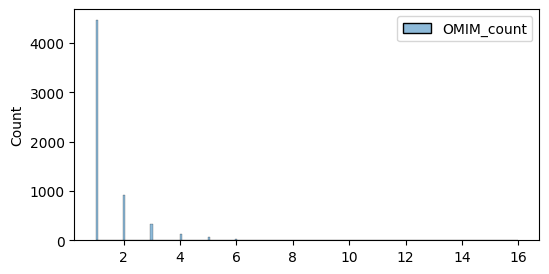

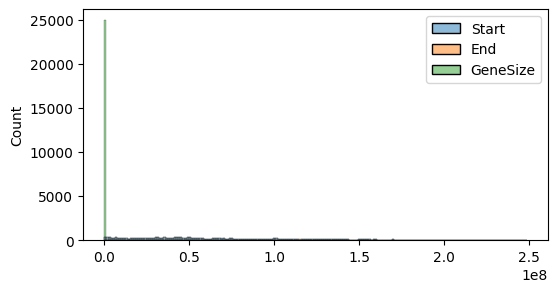

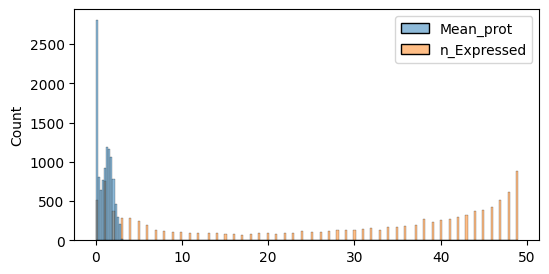

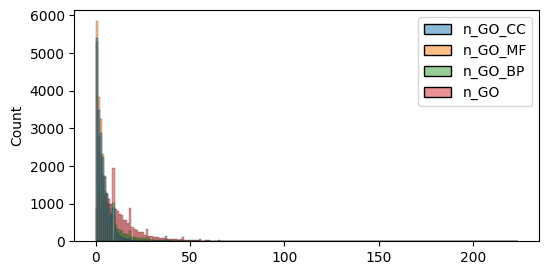

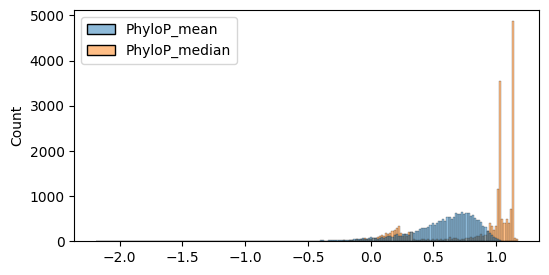

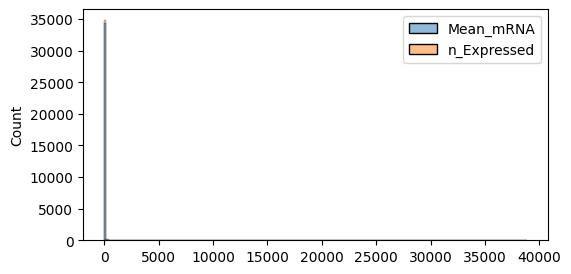

In [446]:
for met, df in annot_dfs.items():
    _ = plt.figure(figsize=(6,3))
    if transform[met] is not None:
        sns.histplot(df, bins=200)
    else:
        sns.histplot(df, bins=200)
    plt.show()

## Check normality assumptions

Even the most normal looking are not normally distributed. I think I will be better off using non-parametric tests. But should I take the log of exponential variables? Probably?

In [65]:
from scipy.stats import kstest
from scipy.stats import anderson
from scipy.stats import normaltest # d-angostino and pearson test
import scipy
from scipy.stats import zscore

In [57]:
annot_dfs['MisSyn'].dropna()['syn.z_score'].values

array([-0.63549 ,  0.017838,  1.8362  , ...,  1.3289  ,  1.1734  ,
        0.058144])

In [75]:
zscore(annot_dfs['MisSyn'].dropna()['mis.z_score'].values)

array([-1.00100205,  0.23228802,  1.1265353 , ...,  0.66418818,
        0.43089862,  0.76287631])

In [70]:
anderson(zscore(annot_dfs['MisSyn'].dropna()['mis.z_score'].values), dist='norm')

AndersonResult(statistic=176.5230676398096, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-3.9079459672208785e-18, scale=1.000027500859407)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

## Initial test


In [101]:
rgenes = pd.read_csv(os.path.join(datadir,'inputs/Jan_2025', '34375979.0_EFO_0004631_RV.txt'), sep='\t').Entrez.unique()
cgenes = pd.read_csv(os.path.join(datadir, 'inputs/Jan_2025','GCST90000618_EFO_0004631_CV.txt'), sep='\t').Entrez.unique()
# one overlapping gene

In [136]:
r_traitlist = pd.read_csv(os.path.join(datadir, 'inputs/Jan_2025', 'rare.traitlist'), header=None)[0].values
c_traitlist = pd.read_csv(os.path.join(datadir, 'inputs/Jan_2025', 'common.traitlist'), header=None)[0].values

In [376]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
def test_annotation(rgenes, cgenes, annot_df, annot_col, metric=np.median, missing_value=None):
    rg = [g for g in rgenes if g in annot_df.dropna(subset=[annot_col]).index.values]
    cg = [g for g in cgenes if g in annot_df.dropna(subset=[annot_col]).index.values]
    if missing_value is None:
        use_df = annot_df.loc[list(rg)+list(cg)]
    else:
        missing = [g for g in rgenes if g not in annot_df.dropna(subset=[annot_col]).index.values] + [g for g in cgenes if g not in annot_df.dropna(subset=[annot_col]).index.values]
        append_df = pd.DataFrame({annot_col: missing_value}, index=missing)
        if len(append_df) > 0:
            use_df = pd.concat([annot_df.loc[list(rg)+list(cg)], append_df])
        else:
            use_df = annot_df.loc[list(rg)+list(cg)]
        rg = rgenes
        cg = cgenes
    if len(rg) > 0 and len(cg) > 0:
        med_rg = metric(use_df.loc[rg][annot_col].values)
        med_cg = metric(use_df.loc[cg][annot_col].values)
        res = mannwhitneyu(use_df.loc[rg][annot_col].values, use_df.loc[cg][annot_col].values)
    else:
        return {'R_med':np.nan, 'C_med': np.nan, 'p': np.nan}
    return {'R_med':med_rg, 'C_med': med_cg, 'p': res.pvalue}

In [383]:
trait_results = []
for i, rt in tqdm(enumerate(r_traitlist[0:400])):
    ct = c_traitlist[i]
    all_res = {}
    rgenes = pd.read_csv(os.path.join(datadir,'inputs/Jan_2025', f'{rt}_RV.txt'), sep='\t').Entrez.unique()
    cgenes = pd.read_csv(os.path.join(datadir,'inputs/Jan_2025',f'{ct}_CV.txt'), sep='\t').Entrez.unique()
    for met, df in annot_dfs.items():
        all_res[met] = test_annotation(rgenes, cgenes, df, usecols[met], missing_value = missing_val[met])
    
    all_res = pd.DataFrame.from_dict(all_res,orient='index').reset_index().dropna()
    all_res['CTrait'] = ct
    all_res['RTrait'] = rt
    all_res['q'] = fdrcorrection(all_res.p.values)[1]
    trait_results.append(all_res)

400it [04:47,  1.39it/s]


In [392]:
df_drop.shape

(3745, 9)

(-1.0, 10.0)

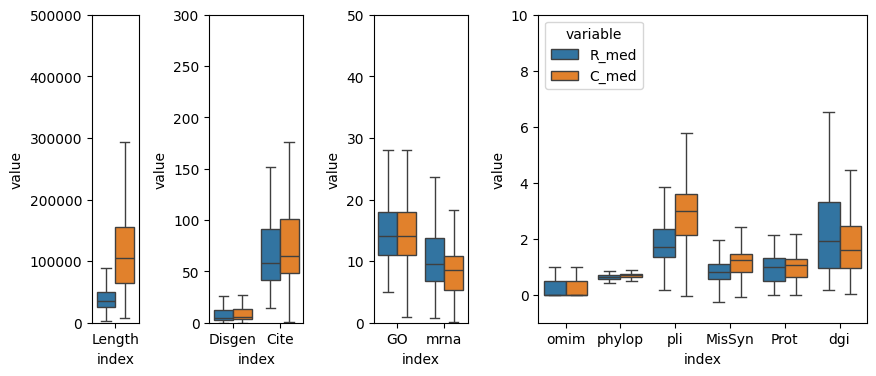

In [393]:
_, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(10, 4), gridspec_kw={'width_ratios':[1,2,2,7], 'wspace':0.5})

sns.boxplot(df_drop[df_drop['index'].isin(['Length'])].loc[:, ('index', 'R_med', 'C_med')].melt(id_vars=['index']), x='index', y='value', 
            hue='variable', fliersize=0, ax=ax1, legend=False)
sns.boxplot(df_drop[df_drop['index'].isin(['Cite', 'Disgen'])].loc[:, ('index', 'R_med', 'C_med')].melt(id_vars=['index']), x='index', y='value', 
            hue='variable', fliersize=0, ax=ax2, legend=False)
sns.boxplot(df_drop[df_drop['index'].isin(['GO', 'mrna'])].loc[:, ('index', 'R_med', 'C_med')].melt(id_vars=['index']), x='index', y='value', 
            hue='variable', fliersize=0, ax=ax3, legend=False)
sns.boxplot(df_drop[~df_drop['index'].isin(['Length', 'GO', 'Cite', 'Disgen', 'mrna'])].loc[:, ('index', 'R_med', 'C_med')].melt(id_vars=['index']), x='index', y='value', 
            hue='variable', fliersize=0, ax=ax4)
ax1.set_ylim(0, 5e5)
ax2.set_ylim(0, 300)
ax3.set_ylim(0, 50)
ax4.set_ylim(-1, 10)

In [394]:
plot_df = df_drop[df_drop['index']=='pli'].reset_index()
plot_df = plot_df.assign(minus_logq = plot_df['logq'] * -1)
plot_df = plot_df.assign(Cmore=plot_df['R_med'] < plot_df['C_med'])
plot_df = plot_df.assign(sig_level=plot_df.logq.apply(lambda z: 0 if z < 1.3 else 1 if z < 3 else 2 if z < 5 else 3))

In [396]:
df_drop.head()

,index,R_med,C_med,p,CTrait,RTrait,q,EFO,logq
6,Length,33377.5,243630.0,1.172734e-13,GCST000821_EFO_0000677,34375979.0_EFO_0000677,1.290008e-12,EFO_0000677,11.889408
6,Length,40565.0,128007.0,1.046610e-09,GCST90309345_EFO_0000684,34375979.0_EFO_0000684,1.151271e-08,EFO_0000684,7.938823
6,Length,11962.0,97361.0,4.776608e-09,GCST90018978_EFO_0004308,34226706.0_EFO_0004308,5.254269e-08,EFO_0004308,7.279488
6,Length,28839.5,95298.0,5.654969e-09,GCST006479_EFO_0009959,34375979.0_EFO_0009959,6.220466e-08,EFO_0009959,7.206177
6,Length,24060.5,237145.5,1.870692e-08,GCST90277988_EFO_0000555,34375979.0_EFO_0000555,2.057762e-07,EFO_0000555,6.686605


In [367]:
p = plot_df.groupby(['Cmore', 'sig_level']).EFO.count().reset_index()

In [317]:
expected = [(354/2) - (354/2)*1e-5, (354/2) - (354/2)*1e-3,(354/2) - (354/2)*0.05]

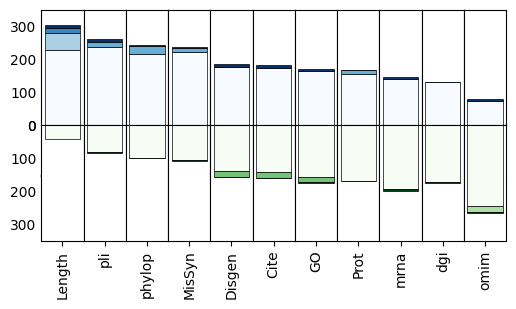

In [409]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=11, figsize=(6,3), gridspec_kw={'hspace':0, 'wspace':0}, sharey='row')

for i, met in enumerate(['Length', 'pli', 'phylop','MisSyn', 'Disgen','Cite',  'GO','Prot', 'mrna', 'dgi', 'omim']):
    plot_df = df_drop[df_drop['index']==met].reset_index()
    plot_df = plot_df.assign(minus_logq = plot_df['logq'] * -1)
    plot_df = plot_df.assign(Cmore=plot_df['R_med'] < plot_df['C_med'])
    plot_df = plot_df.assign(sig_level=plot_df.logq.apply(lambda z: 0 if z < 1.3 else 1 if z < 3 else 2 if z < 5 else 3))
    plot_df[plot_df['Cmore']].groupby(['Cmore', 'sig_level']).size().rename('EFO').unstack().plot(kind='bar', stacked=True, 
            colormap='Blues', ax=ax1[i],edgecolor='black', linewidth=0.5,legend=False)
    plt.xlabel('')
    plt.xticks([])
    plot_df[~plot_df['Cmore']].groupby(['Cmore', 'sig_level']).size().rename('EFO').unstack().plot(kind='bar', stacked=True, 
            colormap='Greens',ax=ax2[i],edgecolor='black', linewidth=0.5, legend=False)
    #ax1[i].hlines(y= (354/2), xmin=-1, xmax=1, color='red', linestyle='--', linewidth=0.5)
    #ax2[i].hlines(y= (354/2), xmin=-1, xmax=1, color='red', linestyle='--', linewidth=0.5)
    for ax in [ax1[i], ax2[i]]:
        ax.set_ylim(0, 350)
        ax.set_xlim(-0.3, 0.3)
        ax.tick_params(axis='y', length=0)
    ax2[i].invert_yaxis()
    ax2[i].set_xlabel('')
    ax2[i].set_xticks([0],[met], rotation=90)


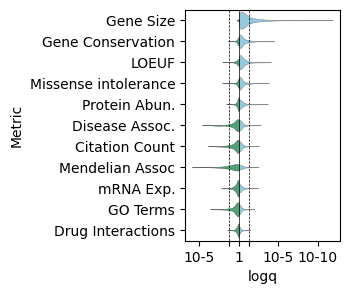

In [444]:
_ = plt.figure(figsize=(2, 3))
df_drop = df_drop.assign(minus_logq = df_drop['logq'] * -1)
plot_df = df_drop.assign(Metric=df_drop['index'].map(labels))
sns.violinplot(plot_df[plot_df.C_med > plot_df.R_med], y='Metric', x='logq', color='skyblue', cut=0, inner=None, 
               density_norm='count', orient='h', linewidth=0.3)
sns.violinplot(plot_df[plot_df.C_med < plot_df.R_med], y='Metric', x='minus_logq', color='mediumseagreen', cut=0, inner=None, 
               density_norm='count', orient='h', linewidth=0.3)
plt.vlines(x=0, ymin=10.5, ymax=-0.5, color='black', linewidth=0.5)
plt.vlines(x=[np.log10(0.05), -1 * np.log10(0.05)], ymin=-0.5, ymax=10.5, linewidth=0.5, linestyle='--', color='black')
plt.ylim(-0.5, 10.5)
plt.gca().invert_yaxis()
_ = plt.xticks([-5, -1.3, 0, 1.3, 5, 10], ['10-5','' , 1,'', '10-5', '10-10'])
plt.savefig

In [399]:
from scipy.stats import wilcoxon
pvals = [] 
for x in df_drop['index'].unique():
    print(x)
    pvals.append(wilcoxon(df_drop[df_drop['index']==x]['C_med'].values, df_drop[df_drop['index']==x]['R_med'].values, nan_policy='omit').pvalue)

Length
omim
Disgen
phylop
pli
Cite
MisSyn
Prot
GO
mrna
dgi


In [400]:
print(pvals)

[1.484768691910988e-45, 0.5296825312469169, 0.11083641698090616, 1.8321712114932725e-12, 3.021276815910201e-22, 0.16155656166088883, 1.099980773076815e-13, 0.33551247504275006, 0.8545959859213177, 0.0007231026132972207, 0.018414518857659934]


In [401]:
fdrcorrection(pvals, alpha=0.05)

(array([ True, False, False,  True,  True, False,  True, False, False,
         True,  True]),
 array([1.63324556e-44, 5.82650784e-01, 1.74171512e-01, 5.03847083e-12,
        1.66170225e-21, 2.22140272e-01, 4.03326283e-13, 4.10070803e-01,
        8.54595986e-01, 1.59082575e-03, 3.37599512e-02]))

In [115]:
test_annotation(rgenes, cgenes, annot_dfs['phylop'], annot_col='PhyloP_mean')

{'R_med': 0.5515767789069584,
 'C_med': 0.6598757009507776,
 'P': 0.592978524496419}

In [105]:
annot_dfs['Cite'].loc[[g for g in cgenes if g in annot_dfs['Cite'].index.values]].describe()

,CitationCount
count,91.000000
mean,164.626374
std,551.118754
min,1.000000
25%,30.500000
50%,55.000000
75%,113.500000
max,5092.000000


In [ ]:
# load gene sets

# load annotation data

# for each feature in the data, perform a rank test But I actually have three classes? Could instead do RO vs CO then 

### should I task this as a classification problem?

# Inputs

In [13]:
rv_gda = pd.read_csv(os.path.join(datadir, 'RAVAR', 'gene_fulltable_06112024.txt.entrez'), sep='\t', low_memory=False, index_col=0)
cv_gda = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedJan29.entrez'), sep='\t', low_memory=False)

In [15]:
all_cv_genes = cv_gda.Entrez.unique()
all_rv_genes = rv_gda.Entrez.unique()
print('CV genes:', len(all_cv_genes))
print('RV genes:', len(all_rv_genes))

CV genes: 17131
RV genes: 12850


In [23]:
def check_genes(annot_df, all_cv_genes, all_rv_genes):
    cv_genes = annot_df[annot_df.Entrez.isin(all_cv_genes)].Entrez.unique()
    rv_genes = annot_df[annot_df.Entrez.isin(all_rv_genes)].Entrez.unique()
    print(f'{100*len(cv_genes)/len(all_cv_genes):.2f}% of CV genes present')
    print(f'{100*len(rv_genes)/len(all_rv_genes):.2f}% of RV genes present')

# Identifier Conversion

In [482]:
from gene_mapper import *

# Features

## Conservation

In [450]:
cons_df = pd.read_csv(os.path.join(refdir, 'gene_conservation_scores.txt'), sep='\t', index_col=0)
cons_df.columns = ['Entrez', 'PhyloP_mean', 'bases', 'PhyloP_median', 'transcript_count']
cons_df.Entrez = cons_df.Entrez.astype(int)
cons_df.bases = cons_df.bases.astype(int)
cons_df = cons_df.rename(columns={'bases': 'CDS_Length'})
cons_df.sort_values(by='Entrez').loc[:, ('Entrez', 'PhyloP_mean', 'PhyloP_median', 'CDS_Length')].to_csv(os.path.join(outdir, 'Gene_PhyloP.txt'), index=False, sep='\t')

In [451]:
cons_df.head()

,Entrez,PhyloP_mean,CDS_Length,PhyloP_median,transcript_count
0,1,0.062387,1488,0.0890,1
1,10,0.299896,678,0.5235,2
2,100,0.548101,1030,1.0260,23
3,1000,0.830825,2605,1.1380,3
4,10000,0.947212,1086,1.1376,10


In [448]:
check_genes(cons_df, all_cv_genes, all_rv_genes)

NameError: name 'check_genes' is not defined

## Citation Counts

In [30]:
cite_df = pd.read_csv(os.path.join(refdir, 'gene_citation_counts_Dec20_2023.txt'), sep='\t', header=None, names=['Entrez', 'CitationCount'])
cite_df.sort_values('Entrez').to_csv(os.path.join(outdir, 'Gene_Citation_Dec23.txt'), sep='\t', index=False)

In [28]:
check_genes(cite_df, all_cv_genes, all_rv_genes)

93.08% of CV genes present
99.94% of RV genes present


## mRNA Expression

In [516]:
rna_raw = pd.read_csv(os.path.join(refdir, 'gtex_median_processed_1.tsv.gz'), sep='\t')
rna_df = rna_raw[~rna_raw.Entrez.isna()].drop(columns=['Ensembl_ID', 'Symbol']).set_index('Entrez')

In [532]:
rna_raw[rna_raw.Symbol=='A2MP1']

,Ensembl_ID,Symbol,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood,Entrez
32782,ENSG00000256069.7,A2MP1,0.616775,0.574134,0.30356,0.110593,0.208008,0.100962,0.354712,0.169046,...,0.114133,0.253864,1.03746,0.119305,0.421854,0.241612,0.443304,0.245679,0.039188,NaN


In [446]:
rna_metrics = pd.DataFrame({'Mean_mRNA':rna_df.mean(axis=1), 'n_Expressed':(rna_df > 1).sum(axis=1)}).reset_index()

In [448]:
rna_metrics = rna_metrics.sort_values(by='Mean_mRNA', ascending=False).drop_duplicates(subset='Entrez', keep='first')

In [451]:
rna_metrics.to_csv(os.path.join(outdir, 'Gene_mRNA.txt'), sep='\t', index=False)

## Protein Expression

In [457]:
prot_raw = pd.read_csv(os.path.join(refdir, 'HPA_processed_protein_abundance.csv'), sep='\t')
prot_df = prot_raw.drop(columns=['Symbol', 'Ensembl_ID']).set_index('Entrez')

In [458]:
prot_metrics = pd.DataFrame({'Mean_prot':prot_df.mean(axis=1), 'n_Expressed':(prot_df > 0.5).sum(axis=1)}).reset_index()

In [460]:
prot_metrics.to_csv(os.path.join(outdir, 'Gene_prot.txt'), sep='\t', index=False)

## GO Annotations

In [464]:
go_df = pd.read_csv(os.path.join(refdir, 'gene2go.gz'), sep='\t')
go_df = go_df[go_df['#tax_id']==9606].drop(columns=['#tax_id'])

In [472]:
# remove negating qualifiers
exclude_qualifiers = [x for x in go_df.Qualifier.unique() if 'NOT' in x]
go_df = go_df[~go_df.Qualifier.isin(exclude_qualifiers)]

In [495]:
go_counts = go_df.groupby(['GeneID', 'Category']).GO_ID.nunique().reset_index()
go_counts = go_counts.pivot_table(index='GeneID', columns=['Category'], values='GO_ID', fill_value=0).reset_index()
go_counts.columns = ['Entrez', 'n_GO_CC', 'n_GO_MF', 'n_GO_BP']
go_counts['n_GO']=go_counts['n_GO_CC'] + go_counts['n_GO_MF'] + go_counts['n_GO_BP']

In [496]:
go_counts.to_csv(os.path.join(outdir, 'Gene_GO.txt'), sep='\t', index=False)

## Disgen Associations

## Gene length

I don't think I can trust Ensembl's Entrez mapping. Instead take the symbols and map to Entrez. 

Exclude any genes that have conflicting gene lengths. 

In [533]:
length_df = pd.read_csv(os.path.join(refdir,'Ensembl_Feb14_2025.txt.gz'), sep='\t',)
length_df.head()

/tmp/ipykernel_2148022/297704599.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  length_df = pd.read_csv(os.path.join(refdir,'Ensembl_Feb14_2025.txt.gz'), sep='\t',)


,Gene stable ID,Transcript stable ID,Gene start (bp),Gene end (bp),Chromosome/scaffold name,Transcript start (bp),Transcript end (bp),Transcription start site (TSS),Transcript length (including UTRs and CDS),Gene % GC content,Gene type,Transcript type,NCBI gene (formerly Entrezgene) ID,HGNC symbol
0,ENSG00000210049,ENST00000387314,577,647,MT,577,647,577,71,40.85,Mt_tRNA,Mt_tRNA,NaN,MT-TF
1,ENSG00000211459,ENST00000389680,648,1601,MT,648,1601,648,954,45.49,Mt_rRNA,Mt_rRNA,NaN,MT-RNR1
2,ENSG00000210077,ENST00000387342,1602,1670,MT,1602,1670,1602,69,42.03,Mt_tRNA,Mt_tRNA,NaN,MT-TV
3,ENSG00000210082,ENST00000387347,1671,3229,MT,1671,3229,1671,1559,42.81,Mt_rRNA,Mt_rRNA,NaN,MT-RNR2
4,ENSG00000209082,ENST00000386347,3230,3304,MT,3230,3304,3230,75,38.67,Mt_tRNA,Mt_tRNA,NaN,MT-TL1


In [535]:
length_df[length_df['HGNC symbol']=='A2MP1']

,Gene stable ID,Transcript stable ID,Gene start (bp),Gene end (bp),Chromosome/scaffold name,Transcript start (bp),Transcript end (bp),Transcription start site (TSS),Transcript length (including UTRs and CDS),Gene % GC content,Gene type,Transcript type,NCBI gene (formerly Entrezgene) ID,HGNC symbol
243217,ENSG00000256069,ENST00000566278,9229376,9275817,12,9229376,9275817,9275817,4130,37.12,transcribed_unprocessed_pseudogene,transcribed_unprocessed_pseudogene,NaN,A2MP1


In [237]:
length_df = pd.read_csv(os.path.join(refdir,'Ensembl_Feb14_2025.txt.gz'), sep='\t', low_memory=False,
                       usecols=['Gene stable ID', 'Gene start (bp)', 'Gene end (bp)', 'Chromosome/scaffold name',
                               'NCBI gene (formerly Entrezgene) ID', 'HGNC symbol'],
                       )
length_df.columns = ['Ensembl', 'Start', 'End', 'Chrom', 'Entrez', 'Symbol']
length_df = length_df.dropna(subset=['Start', 'End', 'Entrez']).drop_duplicates()
length_df = length_df[length_df.Chrom.isin([str(x) for x in range(1, 23)] + ['X', 'Y'])]
length_df = length_df[~length_df.Symbol.isna()]
length_df['GeneSize'] = length_df['End'] - length_df['Start']

In [209]:
updated_symbols, missing = update_nodes(length_df.Symbol.unique(), 'Symbol')
print('Missing:', len(missing))
converted_ids, missing= convert_node_ids(list(updated_symbols.values()), 'Symbol', 'Entrez') 
print('Missing:', len(missing))

Initial Ids 25034
Checking approved symbols
Response received
Check names 37
Previous Ids 20
Checking previous symbols
Missing: 0


In [218]:
gene_map = {x: converted_ids[y] for x,y in updated_symbols.items()}
length_df = length_df.assign(Entrez = length_df.Symbol.map(gene_map))
# remove duplicated gene lengths
length_df = length_df.drop_duplicates(subset=['Entrez', 'GeneSize'])

In [263]:
print('Genes with conflicting entries:',  length_df[length_df.Entrez.duplicated(keep=False)].Entrez.nunique())
# Remove genes with conflicting entries
length_df = length_df[~length_df.Entrez.isin(length_df[length_df.Entrez.duplicated(keep=False)].Entrez.values)]
print('Final size:', len(length_df))

Genes with conflicting entries: 0
Final size: 25013


In [266]:
length_df

,Ensembl,Start,End,Chrom,Entrez,Symbol,GeneSize
4336,ENSG00000292327,333933,386955,Y,28227,PPP2R3B,53022
4348,ENSG00000292332,1336616,1382689,Y,3563,IL3RA,46073
4351,ENSG00000292333,1462581,1537185,Y,286530,P2RY8,74604
4353,ENSG00000292334,1386152,1392113,Y,293,SLC25A6,5961
4357,ENSG00000292338,2219506,2502805,Y,207063,DHRSX,283299
...,...,...,...,...,...,...,...
429339,ENSG00000237950,43937896,43946659,1,105378688,LINC02918,8763
429776,ENSG00000234601,239898016,239953112,1,100873984,CHRM3-AS1,55096
429905,ENSG00000235358,41241772,41338644,1,102723924,SCMH1-DT,96872
429944,ENSG00000293271,94585556,94855426,1,101928079,SLC44A3-AS1,269870


In [267]:
length_df.sort_values('Entrez').loc[:, ('Entrez','Chrom', 'Start', 'End', 'GeneSize')].to_csv(os.path.join(outdir, 'Gene_length.txt'), sep='\t', index=False)

## GWAS associations

## DISGEN

In [497]:
disgen_df = pd.read_csv(os.path.join(refdir, 'gda_BEFREEDec22_2023.tsv.gz'), sep='\t', index_col=0)
disgen_df.head()

,geneid,gene_symbol,uniprotid,gene_dsi,gene_dpi,gene_pli,protein_class,protein_class_name,diseaseid,disease_name,...,disease_class_name,disease_type,disease_semantic_type,score,ei,el,year_initial,year_final,source,diseaseId
0,4547,MTTP,P55157,0.505,0.846,1.040000e-05,DTO_05007405,Transporter,C0000744,Abetalipoproteinemia,...,"Congenital, Hereditary, and Neonatal Diseas...",disease,Disease or Syndrome,0.80,0.982,NaN,1985,2019,BEFREE,C0000744
1,338,APOB,P04114,0.453,0.808,1.923400e-16,NaN,NaN,C0000744,Abetalipoproteinemia,...,"Congenital, Hereditary, and Neonatal Diseas...",disease,Disease or Syndrome,0.20,0.971,NaN,1985,2019,BEFREE,C0000744
2,23230,VPS13A,Q96RL7,0.650,0.577,9.312500e-22,NaN,NaN,C0000744,Abetalipoproteinemia,...,"Congenital, Hereditary, and Neonatal Diseas...",disease,Disease or Syndrome,0.13,1.000,NaN,2007,2018,BEFREE,C0000744
3,51128,SAR1B,Q9Y6B6,0.686,0.462,2.315000e-03,NaN,NaN,C0000744,Abetalipoproteinemia,...,"Congenital, Hereditary, and Neonatal Diseas...",disease,Disease or Syndrome,0.13,1.000,NaN,2011,2016,BEFREE,C0000744
4,80025,PANK2,Q9BZ23,0.559,0.808,7.403400e-07,DTO_03300101,Kinase,C0000744,Abetalipoproteinemia,...,"Congenital, Hereditary, and Neonatal Diseas...",disease,Disease or Syndrome,0.13,0.667,NaN,2005,2015,BEFREE,C0000744


In [501]:
disgen_counts = disgen_df.groupby('geneid').diseaseid.nunique().reset_index()
disgen_counts.columns = ['Entrez', 'n_DISGENET']
disgen_counts.to_csv(os.path.join(outdir, 'Gene_disgen.txt'), sep='\t', index=False)

## OMIM

Simply count the number of phenotypes, assuming all are separated by ';'

In [304]:
omim_df = pd.read_csv(os.path.join(refdir, 'OMIM', 'genemap2.txt'), sep='\t', skiprows=3, skipfooter=76, engine='python',
                     usecols=['MIM Number', 'Gene/Locus And Other Related Symbols', 'Entrez Gene ID', 'Phenotypes'])
omim_df = omim_df[~omim_df.Phenotypes.isna()]
omim_df = omim_df[~omim_df['Entrez Gene ID'].isna()]

In [312]:
omim_df = omim_df.assign(PhenotypeCount=omim_df.Phenotypes.apply(lambda x: len(x.split(';'))))

In [314]:
omim_df[omim_df.PhenotypeCount==16]

,MIM Number,Gene/Locus And Other Related Symbols,Entrez Gene ID,Phenotypes,PhenotypeCount
11067,120140,"COL2A1, STL1, ACG2, SEDC, SEMDSTWK, EDMMD, OSC...",1280.0,?Vitreoretinopathy with phalangeal epiphyseal ...,16


In [322]:
omim_df.rename(columns={'Entrez Gene ID':'Entrez', 'PhenotypeCount':'OMIM_count'}, inplace=True)
omim_df['Entrez'] = omim_df['Entrez'].astype(int)

In [323]:
omim_df.loc[:, ('Entrez', 'OMIM_count')].to_csv(os.path.join(outdir, 'Gene_OMIM.txt'), sep='\t', index=False)

## DGIdb

### Known drug interactions

Number of drugs is inversely correlated with the interaction score. 

In [349]:
dgi_df = pd.read_csv(os.path.join(refdir, 'DGIdb', 'interactions.tsv'), sep='\t')
dgi_df = dgi_df.dropna(subset=['interaction_score', 'drug_concept_id', 'gene_name'])
dgi_df.head()

,gene_claim_name,gene_concept_id,gene_name,interaction_source_db_name,interaction_source_db_version,interaction_type,interaction_score,drug_claim_name,drug_concept_id,drug_name,approved,immunotherapy,anti_neoplastic
0,CYP2D6,hgnc:2625,CYP2D6,DTC,9/2/20,NaN,0.017709,RACLOPRIDE,ncit:C152139,RACLOPRIDE,False,False,False
1,PPARG,hgnc:9236,PPARG,DTC,9/2/20,NaN,0.840123,KALOPANAX-SAPONIN F,chembl:CHEMBL1833984,CHEMBL:CHEMBL1833984,False,False,False
2,ATAD5,hgnc:25752,ATAD5,DTC,9/2/20,NaN,0.177992,RO-5-3335,chembl:CHEMBL91609,CHEMBL:CHEMBL91609,False,False,False
3,RGS4,hgnc:10000,RGS4,DTC,9/2/20,NaN,0.034319,"3,4-DICHLOROISOCOUMARIN",drugbank:DB04459,"3,4-DICHLOROISOCOUMARIN",False,False,False
4,MAPK1,hgnc:6871,MAPK1,DTC,9/2/20,NaN,0.050007,WITHAFERIN A,iuphar.ligand:13097,WITHAFERIN A,False,False,False


In [333]:
dgi_df[dgi_df.gene_claim_name=='CYP3A4'].drug_concept_id.nunique()

890

In [350]:
drug_scores = pd.DataFrame({'n_drugs': dgi_df.drop_duplicates(subset=['gene_name', 'drug_concept_id']).gene_name.value_counts(),
                           'mean_score': dgi_df.drop_duplicates(subset=['gene_name', 'drug_concept_id']).groupby('gene_name').interaction_score.mean()})

In [360]:
np.log10(drug_scores).corr()

,n_drugs,mean_score
n_drugs,1.000000,-0.671699
mean_score,-0.671699,1.000000


<Axes: xlabel='n_drugs', ylabel='mean_score'>

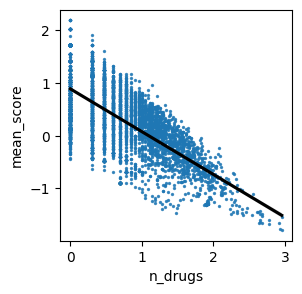

In [370]:
_ = plt.figure(figsize=(3,3))
sns.regplot(np.log10(drug_scores), x='n_drugs', y='mean_score', line_kws={'color':'black'}, scatter_kws={"s":2})

In [374]:
drug_scores = drug_scores.reset_index()

In [376]:
updated_symbols, missing = update_nodes(drug_scores.gene_name.unique(), 'Symbol')
print('Missing:', len(missing))
converted_ids, missing= convert_node_ids(list(updated_symbols.values()), 'Symbol', 'Entrez') 
print('Missing:', len(missing))

Initial Ids 4842
Checking approved symbols
Response received
Check names 131
Previous Ids 121
Checking previous symbols
Alias Ids 119
Searching aliases
Missing: 113
Searching Entrez
Missing: 1


In [377]:
gene_map = {x: converted_ids[y] for x,y in updated_symbols.items() if y in converted_ids}
drug_scores = drug_scores.assign(Entrez = drug_scores.gene_name.map(gene_map))

In [379]:
drug_scores = drug_scores.dropna()

In [381]:
drug_scores.loc[:, ('Entrez', 'n_drugs', 'mean_score')].to_csv(os.path.join(outdir, 'Gene_DGI_scores.txt'))

### Druggability

* Each source has just one version

In [392]:
dgi_cat = pd.read_csv(os.path.join(refdir, 'DGIdb', 'categories.tsv'), sep='\t')
dgi_cat.head()

,name,name-2,source_db_name,source_db_version
0,PXR,NUCLEAR HORMONE RECEPTOR,BaderLab,Feb-14
1,LXRA,NUCLEAR HORMONE RECEPTOR,BaderLab,Feb-14
2,SHP,NUCLEAR HORMONE RECEPTOR,BaderLab,Feb-14
3,DAX,NUCLEAR HORMONE RECEPTOR,BaderLab,Feb-14
4,REV-ERBA,NUCLEAR HORMONE RECEPTOR,BaderLab,Feb-14


In [396]:
dgi_cat_counts = dgi_cat.groupby('name').source_db_name.nunique().reset_index()
dgi_cat_counts.columns = ['Symbol', 'DB_count']

In [398]:
# this is going to take forever..... A lot more that are being done one at a time.
updated_symbols, missing = update_nodes(dgi_cat_counts.Symbol.unique(), 'Symbol')
print('Missing:', len(missing))
converted_ids, missing= convert_node_ids(list(updated_symbols.values()), 'Symbol', 'Entrez') 
print('Missing:', len(missing))

Initial Ids 18809
Checking approved symbols
Response received
Check names 8970
Previous Ids 8852
Checking previous symbols
Alias Ids 8639
Searching aliases
Missing: 8673
Searching Entrez
Missing: 1


In [402]:
gene_map = {x: converted_ids[y] for x,y in updated_symbols.items() if y in converted_ids}
dgi_cat_counts = dgi_cat_counts.assign(Entrez = dgi_cat_counts.Symbol.map(gene_map))

In [403]:
dgi_cat_counts = dgi_cat_counts.dropna()

In [404]:
dgi_cat_counts.rename(columns={'DB_count':'druggability'}, inplace=True)

In [469]:
all_dgi = drug_scores.merge(dgi_cat_counts, on='Entrez', how='outer')
all_dgi.loc[:, ('Entrez', 'n_drugs', 'mean_score', 'druggability')].to_csv(os.path.join(outdir, 'Gene_DGI_scores.txt'), sep='\t', index=False)

## pLoF/Haploinsufficiency
* lof.z_score: Z-score for pLoF variants in transcript. Higher (more positive) Z scores indicate that the transcript is more intolerant of variation (more constrained)  
* lof.pLI: Probability of loss-of-function intolerance; probability that transcript falls into distribution of haploinsufficient genes (~21% o/e pLoF ratio;  computed from high confidence pLoF gnomAD data)  
* lof_hc_lc.pLI: Probability of loss-of-function intolerance; probability that transcript falls into distribution of haploinsufficient genes (~21% o/e pLoF ratio; computed from high and low confidence pLoF gnomAD data)  


* -lof.oe_ci.upper: LOEUF: upper bound of 90% confidence interval for o/e ratio for high confidence pLoF variants (lower values indicate more constrained)

In [453]:
pli_df = pd.read_csv(os.path.join(refdir, 'gnomAD', 'gnomad.v4.1.constraint_metrics.tsv'), sep='\t',
                    usecols=['gene', 'gene_id', 'canonical','mane_select', 'lof.z_score', 'lof.pLI', 'lof_hc_lc.pLI','lof.oe_ci.upper' ])
# exclude non-canonical transcripts
print(pli_df.gene.nunique())
#pli_df = pli_df[pli_df.canonical]
#print(pli_df.gene.nunique())
#pli_df = pli_df[pli_df.mane_select]
#print(pli_df.gene.nunique())

18203


In [455]:
pli_df.corr(numeric_only=True)

,canonical,mane_select,lof_hc_lc.pLI,lof.pLI,lof.oe_ci.upper,lof.z_score
canonical,1.000000,0.959405,-0.063647,-0.061805,0.063109,-0.057221
mane_select,0.959405,1.000000,-0.061371,-0.060047,0.055817,-0.051878
lof_hc_lc.pLI,-0.063647,-0.061371,1.000000,0.982011,-0.701473,0.687378
lof.pLI,-0.061805,-0.060047,0.982011,1.000000,-0.697116,0.685251
lof.oe_ci.upper,0.063109,0.055817,-0.701473,-0.697116,1.000000,-0.858605
lof.z_score,-0.057221,-0.051878,0.687378,0.685251,-0.858605,1.000000


In [414]:
gene_df = pli_df[pli_df.gene=='A1BG']

In [415]:
gene_df

,gene,gene_id,canonical,mane_select,lof_hc_lc.pLI,lof.pLI,lof.oe_ci.upper,lof.z_score
0,A1BG,1,True,True,1.625600e-16,1.770600e-16,1.340,-0.25212
1,A1BG,ENSG00000121410,True,True,1.625600e-16,1.770600e-16,1.340,-0.25212
2,A1BG,ENSG00000121410,False,False,2.530600e-08,1.836500e-07,1.256,0.50934


In [456]:
dups = gene_df.duplicated(subset=['lof.pLI', 'lof.z_score', 'lof_hc_lc.pLI', 'lof.oe_ci.upper'], keep='first')

NameError: name 'gene_df' is not defined

In [417]:
gene_df[~dups].index.values[0]

0

In [457]:
def prioritize_gene_duplicates(df, gene, score_cols):
    """Where there are multiple distinct entries for a gene, we first prioritize those representing canonical transcripts. 
    If there are multiple or no canonical transcripts we next prioritize MANE Select transcripts. Where these filters are 
    unable to produce a single gene entry, we prioritize the entry assigned an NCBI Gene ID. """
    # sort such that NCBI Gene IDs will be first
    gene_df = df[df.gene==gene].sort_values('gene_id')
    if len(gene_df) == 0:
        return None
    # if there is only one entry, take this entry
    if len(gene_df)==1:
        return gene_df.index.values[0]
    # if there are multiple entries
    else:
        # if all entries have the same scores, take the first ID (will be NCBI Gene ID if available)
        if len(gene_df.drop_duplicates(subset=score_cols)) == 1:
            # results are all the same anyway. Return the entry with entrez id
            return gene_df.index.values[0]
        
        # Otherwise, we need to prioritize amongst the results
        else:
            # is there at least one canonical transcript
            if len(gene_df[(gene_df.canonical)]) >= 1:
                gene_df = gene_df[gene_df.canonical]
                
            # is there at least one mane select transcript
            if len(gene_df[(gene_df.mane_select)]) >= 1:
                gene_df = gene_df[gene_df.mane_select]
                
            # at this point all entries should have the same values for canonical and mane_select
            # check if these prioritizations have left us with just one entry
            if len(gene_df) == 1:
                return gene_df.index.values[0]
            
            # check if there are any duplicates
            dups = gene_df.duplicated(subset=score_cols, keep='first')
            if sum(dups) > 0:
                # take the duplicated values as the correct ones.
                return gene_df[~dups].index.values[0]
            
            # any dfs making it here have different scores, but same transcript designations
            return gene_df.index.values[0]

                
 

In [458]:
out = []
for gene in tqdm(pli_df.gene.unique()):
    out.append(prioritize_gene_duplicates(pli_df, gene, score_cols=['lof.pLI', 'lof.z_score', 'lof_hc_lc.pLI', 'lof.oe_ci.upper']))

100%|██████████| 18204/18204 [04:22<00:00, 69.44it/s]


In [498]:
gene_pli = pli_df.iloc[out[:-1], :]

In [461]:
gene_pli.head()

,gene,gene_id,canonical,mane_select,lof_hc_lc.pLI,lof.pLI,lof.oe_ci.upper,lof.z_score
0,A1BG,1,True,True,1.625600e-16,1.770600e-16,1.340,-0.252120
8,A1CF,29974,True,True,7.317200e-10,7.656000e-10,0.825,2.528600
23,A2M,2,True,True,9.325900e-20,9.756800e-20,0.765,3.647500
33,A2ML1,144568,True,True,9.885400e-41,1.712700e-40,0.953,1.898600
45,A3GALT2,127550,True,True,2.172400e-19,1.016900e-06,1.529,-0.075727


In [499]:
# replace with NCBI IDs as needed
print('# Ensembl IDs:', len(gene_pli[~gene_pli.gene_id.str.isnumeric()]))

# Ensembl IDs: 749


In [500]:
gene_map = pli_df.loc[pli_df.gene_id.str.isnumeric(), ('gene', 'gene_id')].merge(gene_pli[~gene_pli.gene_id.str.isnumeric()], on='gene', suffixes=('', 'x'), how='right').drop_duplicates(subset=['gene'])
gene_pli = pd.concat([gene_pli[gene_pli.gene_id.str.isnumeric()], gene_map])#.drop(columns=['gene_idx', 'canonical', 'mane_select'])

In [501]:
gene_pli.shape

(18203, 9)

In [502]:
gene_pli = gene_pli.dropna(subset='lof.oe_ci.upper')
print(len(gene_pli))
gene_pli = gene_pli.dropna(subset='gene_id')
print(len(gene_pli))

17957
17919


In [491]:
missing_pli = gene_pli[gene_pli.gene_id.isna()]

In [487]:
missing_sym = gene_pli[gene_pli.gene_id.isna()]['gene'].values

In [490]:
updated_symb, missing = update_nodes(missing_sym, 'Symbol')
print('Missing:', len(missing))
converted_ids, missing= convert_node_ids(list(updated_symb.values()), 'Symbol', 'Entrez') 
print('Missing:', len(missing))

Initial Ids 38
Checking approved symbols
Response received
Check names 9
Previous Ids 7
Checking previous symbols
Missing: 0
Searching Entrez
Missing: 0


In [503]:
missing_pli['gene_id'] = missing_pli.gene.apply(lambda x: converted_ids[updated_symb[x]])

In [504]:
gene_pli = pd.concat([gene_pli, missing_pli ])

In [511]:
gene_pli = gene_pli.drop_duplicates(subset=['gene_id', 'lof.oe_ci.upper'])

In [512]:
print(len(gene_pli), gene_pli.gene_id.nunique())

17954 17954


In [513]:
gene_pli = gene_pli.drop(columns=['gene_idx', 'canonical', 'mane_select'])

In [514]:
gene_pli.columns = ['Symbol', 'Entrez', 'lof_hc_lc.pLI', 'lof.pLI', 'lof.z_score', 'LOEUF']

In [515]:
gene_pli.loc[:, ('Entrez', 'lof.pLI', 'lof.z_score', 'LOEUF')].to_csv(os.path.join(outdir, 'Gene_pLI.txt'), index=False, sep='\t')

## Missense/Synonymous Tolerance

* -mis.z_score: Z-score for missense variants in transcript. Higher (more positive) Z scores indicate that the transcript is more intolerant of variation (more constrained)
* -syn.z_score: Z-score for synonymous variants in transcript. Higher (more positive) Z scores indicate that the transcript is more intolerant of variation (more constrained).


In [154]:
mis_df = pd.read_csv(os.path.join(refdir, 'gnomAD', 'gnomad.v4.1.constraint_metrics.tsv'), sep='\t',
                    usecols=['gene', 'gene_id', 'canonical','mane_select', 'mis.z_score', 'syn.z_score'])
# exclude non-canonical transcripts
print(mis_df.gene.nunique())

18203


In [158]:
out = []
for gene in tqdm(mis_df.gene.unique()):
    out.append(prioritize_gene_duplicates(mis_df, gene, score_cols=['mis.z_score', 'syn.z_score']))

100%|██████████| 18204/18204 [04:07<00:00, 73.49it/s]


In [163]:
gene_mis = mis_df.iloc[out[:-1], :]
len(gene_mis)

18203

In [164]:
# replace with NCBI IDs as needed
print('# Ensembl IDs:', len(gene_mis[~gene_mis.gene_id.str.isnumeric()]))

# Ensembl IDs: 740


In [166]:
gene_map = mis_df.loc[mis_df.gene_id.str.isnumeric(), ('gene', 'gene_id')].merge(gene_mis[~gene_mis.gene_id.str.isnumeric()], on='gene', suffixes=('', 'x'), how='right').drop_duplicates(subset=['gene'])
gene_mis = pd.concat([gene_mis[gene_mis.gene_id.str.isnumeric()], gene_map]).drop(columns=['gene_idx', 'canonical', 'mane_select'])

In [170]:
gene_mis.columns = ['Symbol', 'Entrez', 'mis.z_score', 'syn.z_score']

In [171]:
gene_mis.loc[:, ('Entrez', 'mis.z_score', 'syn.z_score')].to_csv(os.path.join(outdir, 'Gene_MisSyn.txt'), index=False, sep='\t')

## TODO CNV Frequency